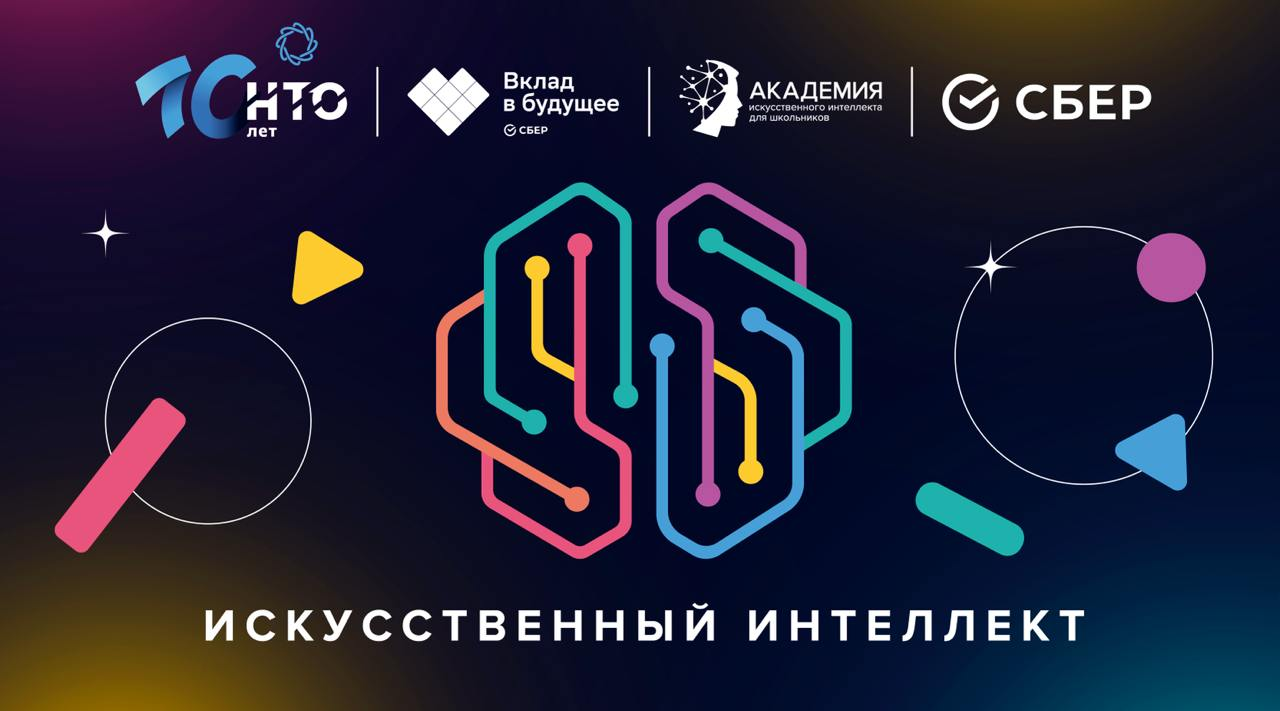

# Baseline для детекции животных по фотографии
Перед вами базовое решение, позволяющие обучить модель машинного обучения обучения для обнаружения животных на фотографиях и определения его группы.
В данном ноутбуке также приведен пример формирования файла с предсказаниями работы модели, на основании которого проводится оценка предсказания модели.

Под задачей детекции животных на изображении понимается задача машинного обучения, в рамках которой выполняется определение наличия или отсутствия животного на изображении, нахождение границ этого животного в системе координат пикселей исходного изображения и определение группы животного.

Код ниже состоит из четырёх основных частей:

- Установка и импорт библиотек, требуемых для работы
- Исследовательский анализ данных
- Подготовка данных для обучения модели  YOLO
- Обучение базовой модели
- Запуск модели и формирование сабмита.


# Установка и импорт библиотек

In [ ]:
!pip install imgviz ultralytics pyyaml

In [ ]:

# Загрузка необходимых библиотек для обучения YOLO
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from pathlib import Path
from shutil import copy
import argparse
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO

import os

import numpy as np
import imgviz
from PIL import Image
from numpy import asarray

from shutil import copy
from sklearn.model_selection import train_test_split

import argparse
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



# Исследовательский анализ данных




Данные содержат информацию:
- image_name - название файла
- detection - координаты ограничивающего прямоугольника (bounding box)
        в формате "label_1 cx_1 cy_1 w_1 h_1;label_2 cx_2 cy_2 w_2 h_2; ... ;label_n cx_n cy_n w_n h_n",
        где label_i - класс, к которому относится животное, (cx_i, cy_i) - координата центра i-го прямоугольника (в относительных значениях), a w_i, h_i - ширена и высота i-го прямоугольника (в относительных значениях).


In [ ]:
# Загрузка csv файла с аннотациями.
train_df_path = "data/train.csv"
train_images_dir = "data/train"

train_df = pd.read_csv(train_df_path)
train_df.head()

image_name  \
0  d4b681c636be92a99d2169685169ddce.JPG   
1  af429cc238c384111b2f6e4ace00638c.JPG   
2  2329fe3d86fa593db201c3897ad74d4c.JPG   
3  309c121c529fb223e87ac1ea9d43073c.JPG   
4  9060b55db1f35ce70948388b0e0158ba.JPG   

                                           detection  
0  4 0.5298713445663452 0.42401960492134094 0.253...  
1  6 0.6738590002059937 0.6928213834762573 0.5684...  
2  1 0.1510416716337204 0.463131308555603 0.23749...  
3  6 0.6556299924850464 0.7617244720458984 0.6808...  
4  5 0.7708333134651184 0.5369875431060791 0.4583...

In [ ]:
# Инициализация пустых списков для хранения меток и координат ограничивающих рамок
label_data = []
cx_data, cy_data, w_data, h_data = [], [], [], []

# Проход по каждой строке в обучающем наборе данных
for index, row in train_df.iterrows():
    # Каждая строка (row['detection']) содержит строку с боксами объектов, разделенными точкой с запятой
    for markup in row['detection'].split(";"):
        # Извлекаем метку и координаты ограничивающей рамки (центр x, центр y, ширина, высота)
        label, cx, cy, w, h = markup.split()

        # Преобразуем координаты из строки в число с плавающей точкой для дальнейших вычислений
        cx = float(cx)
        cy = float(cy)
        w = float(w)
        h = float(h)

        # Добавляем метку и координаты ограничивающей рамки в соответствующие списки
        label_data.append(label)
        cx_data.append(cx)
        cy_data.append(cy)
        w_data.append(w)
        h_data.append(h)


<Figure size 640x480 with 0 Axes>

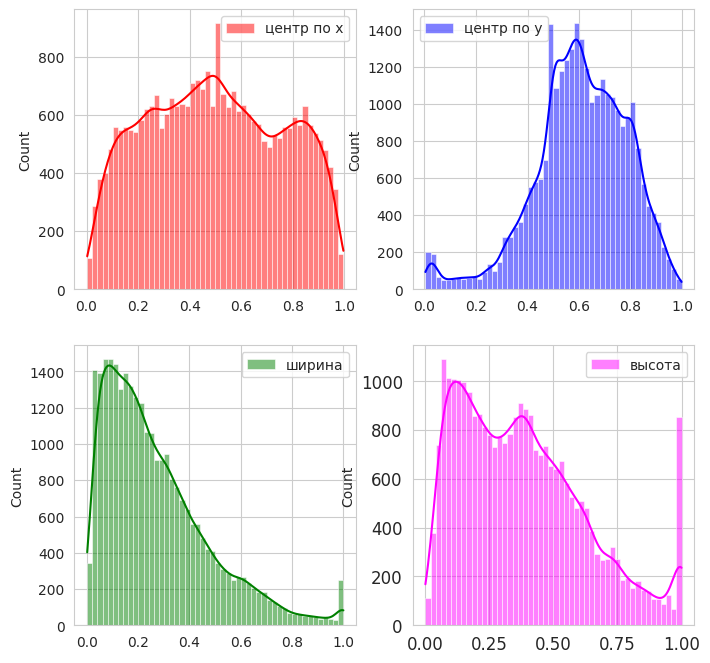

In [ ]:
# Установка стиля графиков
sns.set_style('whitegrid')

# Создание фигуры и сетки из подграфиков 2x2 для размещения каждого графика отдельно
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Построение гистограммы распределения координаты центра по оси X с использованием KDE (оценка плотности)
sns.histplot(cx_data, kde=True, bins=50, color="red", ax=ax[0, 0], label='центр по х')

# Построение гистограммы распределения координаты центра по оси Y
sns.histplot(cy_data, kde=True, bins=50, color="blue", ax=ax[0, 1], label='центр по у')

# Построение гистограммы распределения ширины объектов
sns.histplot(w_data, kde=True, bins=50, color="green", ax=ax[1, 0], label='ширина')

# Построение гистограммы распределения высоты объектов
sns.histplot(h_data, kde=True, bins=50, color="magenta", ax=ax[1, 1], label='высота')

# Отображение легенды для каждого графика
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

# Настройка размеров меток на осях для улучшения читаемости
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

# Показать графики
plt.show()


In [ ]:
# Определение минимального и максимального значений для ширины bounding box
width_data_min = np.min(w_data)
width_data_max = np.max(w_data)

# Определение минимального и максимального значений для высоты bounding box
height_data_min = np.min(h_data)
height_data_max = np.max(h_data)

# Вывод максимального и минимального значений для ширины и высоты bounding box
print(f"Высота bounding box максимальная {height_data_max} и минимальная {height_data_min}")
print(f"Ширина bounding box максимальная {width_data_max} и минимальная {width_data_min}")


Высота bounding box максимальная 1.0 и минимальная 0.0014204978942871094
Ширина bounding box максимальная 1.0 и минимальная 0.00146484375


Давайте посчитаем количество животных на изображении.

In [ ]:
def count_bbox(row):
    # Разделяем строку с аннотацией по символу ";", чтобы получить список bounding boxes
    # Возвращаем количество элементов в списке, что соответствует числу bounding boxes
    return len(row.split(";"))


In [ ]:
# Применение функции count_bbox к каждому элементу столбца "detection"
# Результат сохраняется в новом столбце "count_bbox"
train_df["count_bbox"] = train_df["detection"].apply(lambda x: count_bbox(x))


<Axes: >

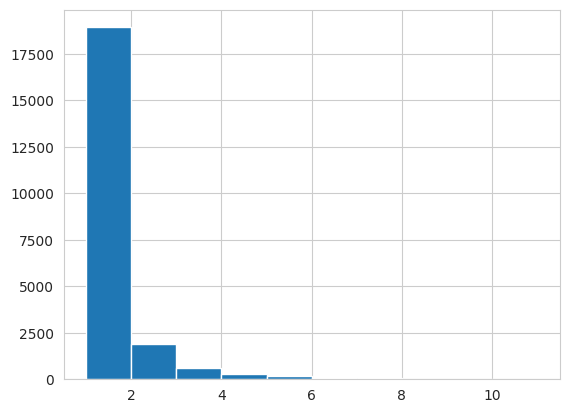

In [ ]:
# Построение гистограммы для визуализации распределения количества bounding boxes
train_df["count_bbox"].hist()

In [ ]:
MAPPER = ['Заяц', 'Кабан', 'Кошки', 'Куньи', 'Медведь', 'Оленевые', 'Пантеры', 'Полорогие', 'Собачие', 'Сурок']

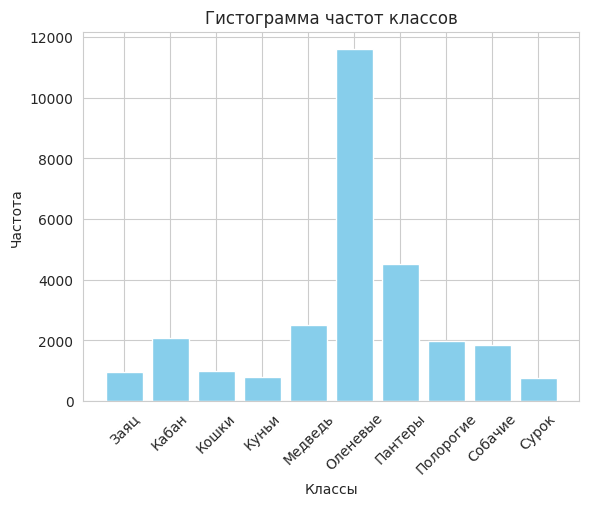

In [ ]:
# Подсчет частот каждого уникального класса в датасете
unique, counts = np.unique(label_data, return_counts=True)

# Преобразование меток классов в названия групп с помощью списка MAPPER
labels = []
for id in unique:
    labels.append(MAPPER[int(float(id))])

# Построение гистограммы частот классов
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Классы')  # Метка для оси X
plt.ylabel('Частота')  # Метка для оси Y
plt.title('Гистограмма частот классов')  # Заголовок графика
plt.xticks(labels, rotation=45)  # Установка меток на оси X с поворотом на 45 градусов для лучшей читаемости
plt.show()


## Визуализация ограничивающих прямоугольников

In [ ]:
# Функция для визуализации bounding boxes на изображении
def visualize_bbox(img, labels, bboxes, class_names):

    # Создаем подписи для каждого box-а на основе меток классов
    captions = [class_names[label_id] for label_id in labels]

    # Визуализация bounding boxes на изображении с помощью imgviz.instances2rgb
    bbox_viz = imgviz.instances2rgb(
        image=img,                    # Исходное изображение
        bboxes=bboxes,                # Координаты bounding boxes
        labels=labels,                # Метки классов для каждого box-а
        captions=captions,            # Подписи классов
        colormap=imgviz.label_colormap(n_label=10),  # Цветовая карта для классов
        font_size=50,                 # Размер шрифта для подписей
        line_width=10                 # Ширина линии для рамок
    )

    # Отображение изображения с наложенными bounding boxes
    plt.figure(dpi=200)
    plt.imshow(bbox_viz)
    plt.axis("off")  # Убираем оси для лучшей видимости изображения


In [ ]:
import os
from PIL import Image
import numpy as np

# Функция для визуализации боксов на изображении по индексу строки в csv файле
def visualization_by_idx(images_dir, train_df, idx, MAPPER):
    # Загружаем изображение
    image_path = os.path.join(images_dir, train_df.loc[idx]["image_name"])
    img = Image.open(image_path)

    # Списки для хранения координат боксов и меток
    bboxes = []
    labels = []

    # Получаем размеры изображения
    img_w, img_h = img.size

    # Парсим аннотации детекции (формат: "метка cx cy w h")
    for markup in train_df.loc[idx]["detection"].split(";"):
        label, cx, cy, w, h = markup.split()
        label = int(label)    # Преобразуем метку в целое число
        cx = float(cx)        # Преобразуем cx в число с плавающей точкой
        cy = float(cy)        # Преобразуем cy в число с плавающей точкой
        w = float(w)          # Преобразуем ширину в число с плавающей точкой
        h = float(h)          # Преобразуем высоту в число с плавающей точкой

        # Преобразуем координаты из относительных (нормализованных) в пиксельные значения
        x1 = int((cx - w / 2) * img_w)  # Левая граница бокса
        x2 = int((cx + w / 2) * img_w)  # Правая граница бокса
        y1 = int((cy - h / 2) * img_h)  # Верхняя граница бокса
        y2 = int((cy + h / 2) * img_h)  # Нижняя граница бокса

        # Добавляем метки и боксы в соответствующие списки
        labels.append(label)
        bboxes.append([y1, x1, y2, x2])  # Формат для визуализации: [y1, x1, y2, x2]

    # Визуализируем изображение с боксовыми аннотациями (предполагается, что функция visualize_bbox уже определена)
    visualize_bbox(np.asarray(img), labels, bboxes, MAPPER)


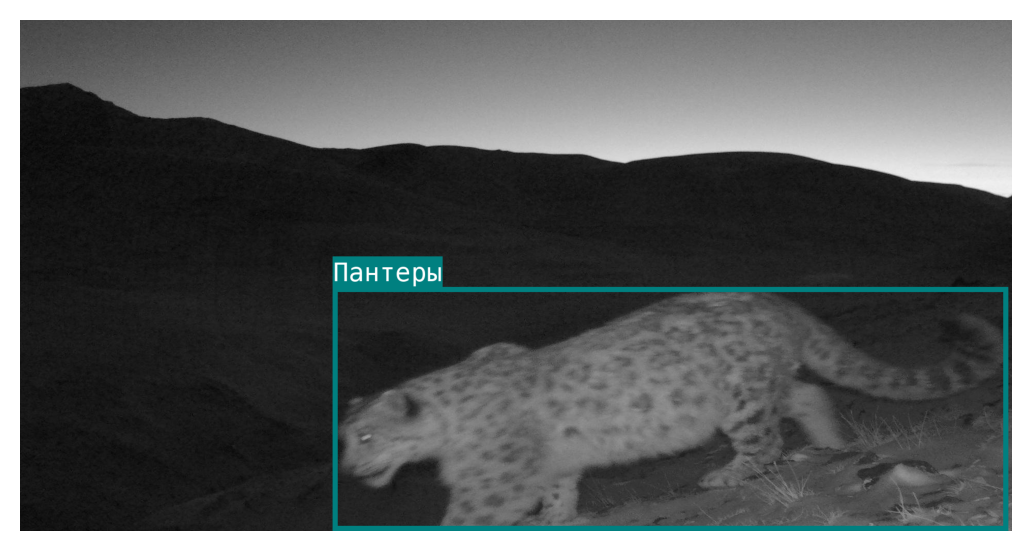

In [ ]:
idx = 3 # Индекс строки для визуализации
visualization_by_idx(train_images_dir, train_df, idx, MAPPER)

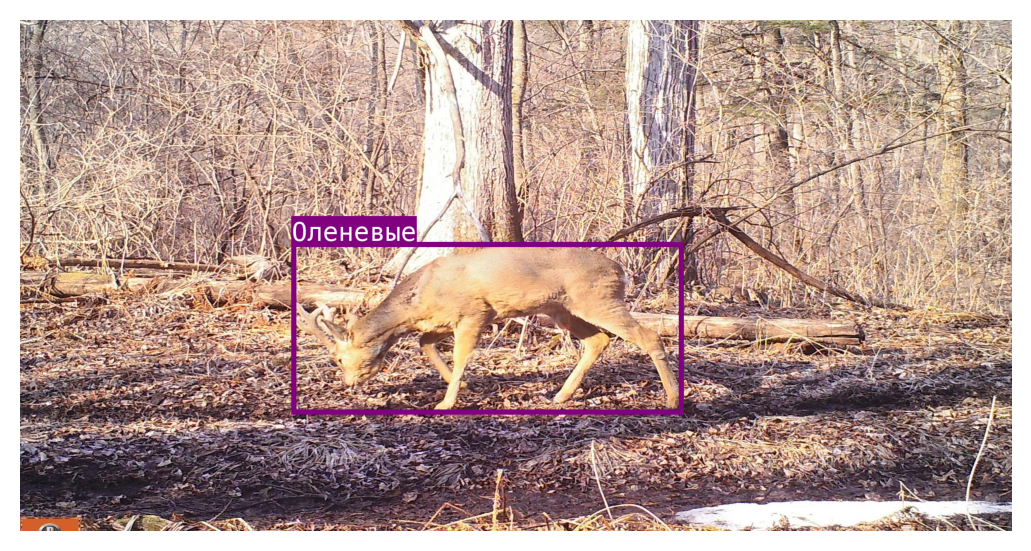

In [ ]:
idx = 9 # Индекс строки для визуализации
visualization_by_idx(train_images_dir, train_df, idx, MAPPER)

# Baseline на основе Yolo
## Предподготовка данных для обучения модели для детекции
Для обучения модели Yolo необходимо разбить данные на обучающую и валидационные выборки.
Создать структуру для обучения


In [ ]:
def preprocess_markup_yolo(save_path, images_dir, file_name, split, markup):
    # Создаем необходимые директории, если они не существуют
    labels_dir = os.path.join(save_path, "labels", split)
    images_dir_dest = os.path.join(save_path, "images", split)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir_dest, exist_ok=True)

    # Обработка аннотаций
    yolo_markups = []
    for det in markup.split(";"):
        yolo_markups.append(f"{det}\n")

    # Сохраняем аннотации в файл
    label_file_path = os.path.join(labels_dir, file_name[:-4] + ".txt")
    with open(label_file_path, "w") as f:
        f.writelines(yolo_markups)

    # Копируем изображение в целевую папку
    image_source_path = os.path.join(images_dir, file_name)
    image_dest_path = os.path.join(images_dir_dest, file_name)
    copy(image_source_path, image_dest_path)

In [ ]:
def yolo_files_split(data_df_path, yolo_data_dir, images_data_dir):
    # Загружаем данные из CSV
    data_df: pd.DataFrame = pd.read_csv(data_df_path)

    # Разделяем на обучающие и валидационные данные
    data_df_train, data_df_val = train_test_split(data_df, test_size=0.33, random_state=42)

    # Обрабатываем обучающие данные
    for index, row in data_df_train.iterrows():
        preprocess_markup_yolo(yolo_data_dir, images_data_dir, row["image_name"], "train", row["detection"])

    # Обрабатываем валидационные данные
    for index, row in data_df_val.iterrows():
        preprocess_markup_yolo(yolo_data_dir, images_data_dir, row["image_name"], "val", row["detection"])


In [ ]:
data_df_path = "data/train.csv"
yolo_data_dir = "yolo/"
images_data_dir = "data/train"

In [ ]:
Path("yolo/images/train").mkdir(exist_ok=True, parents=True)
Path("yolo/images/val").mkdir(exist_ok=True, parents=True)
Path("yolo/labels/train").mkdir(exist_ok=True, parents=True)
Path("yolo/labels/val").mkdir(exist_ok=True, parents=True)

In [ ]:
yolo_files_split(data_df_path, yolo_data_dir, images_data_dir)

In [ ]:
# загрузка необходимых библиотек
import yaml

# Пример данных для конфигурации YOLO
data = {
    'train': '/content/yolo/images/train',  # путь к обучающим изображениям
    'val': '/content/yolo/images/val',  # путь к изображениям для валидации
    'nc': 10,  # количество классов
    'names': ['Заяц', 'Кабан', 'Кошки', 'Куньи', 'Медведь', 'Оленевые', 'Пантеры', 'Полорогие', 'Собачие', 'Сурок']  # имена классов
}

# Сохранение данных в YAML файл
with open('yolo/yolo_config.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, allow_unicode=True)

print("YAML файл успешно создан!")

YAML файл успешно создан!


# Обучение YOLO модели

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
# функция инициализации и обучения модели
def train(model_name, data_yaml):
    model = YOLO(model_name)
    training_results = model.train(
        data=data_yaml,
        epochs=25, # число эпох для обучения
        imgsz=640, # размер изображения для обучения
        batch=16, # размер батча для обучения
        device=0, # номер девайса для обучения
        single_cls=False # для обучения с учетом классов на основании data.yaml
    )

In [ ]:
train("yolov8m.pt", "yolo/yolo_config.yaml")

# Пример инференса модели

In [ ]:
def detection_image(image_path, detection_model):
    # Инициализация пустого списка для хранения меток и координат ограничивающих рамок
    detections = []
    # Выполняем предсказание на изображении
    results = detection_model(image_path)
    # Получаем результаты (предполагается, что результаты содержат список/кортеж)
    results = results[0]
    # Возвращаем пустую строку, если объектов нет
    if len(results.boxes.xyxy.cpu()) == 0:
        return ""

    else:
        # Для каждого найденного объекта (класс, координаты бокса, уверенность)
        for cls, xywhn, conf in zip(results.boxes.cls.cpu(), results.boxes.xywhn.cpu(), results.boxes.conf.cpu()):
            # Форматируем результаты в строку "class_id x_min y_min x_max y_max confidence"
            detections.append(" ".join([
                str(cls.item()),
                str(xywhn[0].item()),
                str(xywhn[1].item()),
                str(xywhn[2].item()),
                str(xywhn[3].item()),
                str(conf.item())])
            )

        # Объединяем все боксы в одну строку через ";"
        return ";".join(detections)

In [ ]:
import pandas as pd
import os
from pathlib import Path

def inference(detection_model, test_image_dir, output_path):
   # Инициализация пустых списков для имен изображений и предсказаний
    results_name = []
    results_detection = []

    # Перебор изображений в директории
    for image_name in os.listdir(test_image_dir):
        image_path = os.path.join(test_image_dir, image_name)

        # Детекция объектов на изображении
        result_detect = detection_image(image_path=image_path, detection_model=detection_model)
        # Добавляем имя изображения в результирующий список
        results_name.append(Path(image_name).name)
        # Добавляем предсказание для изображения в результирующий список
        results_detection.append(result_detect)

    # Создаем DataFrame для результатов
    df_result = pd.DataFrame({
        "image_name": results_name,
        "predicted_detection": results_detection
    })

    # Сохраняем результаты в CSV
    df_result.to_csv(output_path, index=False)



In [ ]:
# запуск модели и выгрузка файла с результатами работы модели
path_detection_model_cpt = Path("/content/runs/detect/train3/weights/best.pt")
output_path = Path("submission.csv")
dir_test_images = Path("data/check/images")

detection_model = YOLO(path_detection_model_cpt)
inference(detection_model, dir_test_images, output_path)


image 1/1 /content/data/check/images/33b77baab3631df093b83427621b322a.JPG: 352x640 1 Заяц, 18.6ms
Speed: 2.3ms preprocess, 18.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/data/check/images/ac393e861c5d6f63171561c5f1c74774.JPG: 352x640 1 Кабан, 18.6ms
Speed: 3.3ms preprocess, 18.6ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/data/check/images/d386a16ce6c13508d3ef6f14f0215487.JPG: 352x640 1 Оленевые, 1 Полорогие, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/data/check/images/5ca05eff48ec2535f192b9dec32415b7.JPG: 352x640 1 Кошки, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /content/data/check/images/16a1f4840dc8dc159a7ed868e1eb7d9f.JPG: 352x640 2 Оленевыеs, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 6

## Визуализируем результаты предсказания

In [ ]:
def visualization_by_idx_prediction(images_dir, train_df, idx, MAPPER):
    # Извлекаем путь к изображению по индексу
    image_path = os.path.join(images_dir, train_df.loc[idx]["image_name"])
    img = Image.open(image_path)

    # Инициализация пустых списков для хранения координат боксов и меток
    bboxes = []
    labels = []

    img_w, img_h = img.size  # Ширина и высота изображения

    # Разбираем предсказания для данного изображения
    for markup in train_df.loc[idx]["predicted_detection"].split(";"):
        # Обработка предсказания: label, cx, cy, w, h, conf
        label, cx, cy, w, h, conf = markup.split()
        # Преобразуем метку в целое число
        label = int(float(label))
        # Преобразуем координаты в float
        cx, cy, w, h = map(float, [cx, cy, w, h])

        # Предобрабатываем координаты боксов в пикселях
        x1 = int((cx - w/2) * img_w)
        x2 = int((cx + w/2) * img_w)
        y1 = int((cy - h/2) * img_h)
        y2 = int((cy + h/2) * img_h)

        # Добавляем метки и боксы в соответствующие списки
        labels.append(label)
        bboxes.append([y1, x1, y2, x2])

    # Визуализируем боксы на изображении
    visualize_bbox(asarray(img), labels, bboxes, MAPPER)

In [ ]:
# чтение csv файла с предсказаниями
submission_df = pd.read_csv("submission.csv")

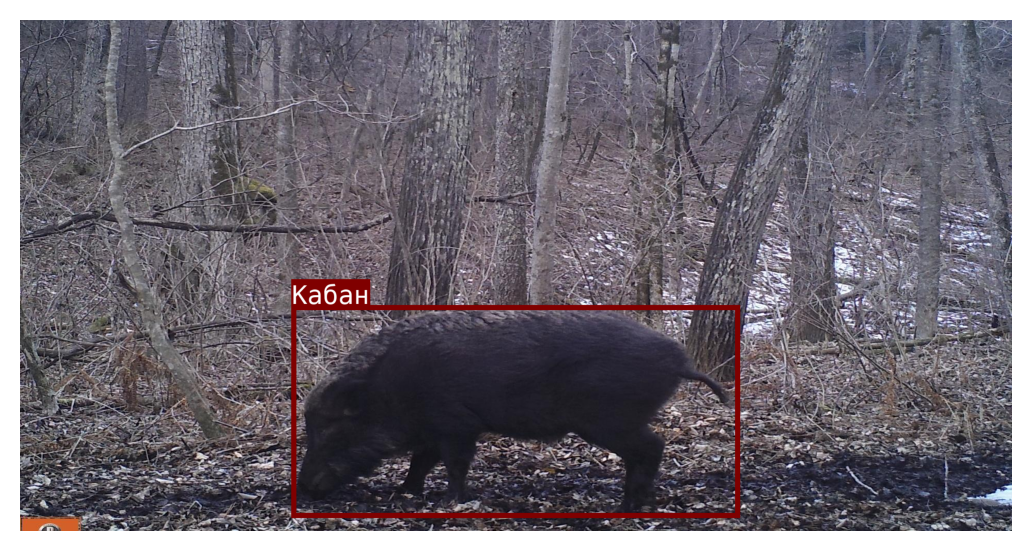

In [ ]:
idx = 1 # Индекс строки для визуализации
visualization_by_idx_prediction(dir_test_images, submission_df, idx, MAPPER)